In [1]:
from fileinput import filename
from operator import index
import click
import logging
from pathlib import Path
from dotenv import find_dotenv, load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os.path


import torch
from torchvision.models import resnet50,densenet121
from torch.nn.functional import sigmoid
from sklearn.metrics import roc_auc_score,f1_score

from torch.utils.data import DataLoader
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, StratifiedGroupKFold
from src.data.pytorch_dataset import MaskingDataset

import shap
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/theo/miniconda3/envs/mmc_masking/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NoDiscBB_0 NoDiscBB

FOLD 0
tensor([[0.]])
tensor([[0.2521]], device='cuda:0', grad_fn=<AddmmBackward0>) tensor([[0.5627]], device='cuda:0', grad_fn=<SigmoidBackward0>)


PartitionExplainer explainer: 2it [00:25, 25.31s/it]               

0.019856154918670686 0.23223939538002014 0.25209555029869085



/home/theo/miniconda3/envs/mmc_masking/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


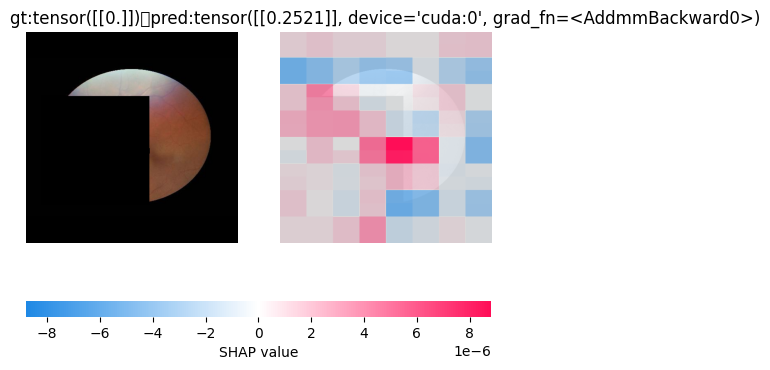

tensor([[0.]])
tensor([[0.0728]], device='cuda:0', grad_fn=<AddmmBackward0>) tensor([[0.5182]], device='cuda:0', grad_fn=<SigmoidBackward0>)


KeyboardInterrupt: 

In [2]:
def generate_explainability_map():
    #Get hyperparameters 
    NB_FOLDS = int(os.environ.get("NB_FOLDS"))
    BATCH_SIZE = int(os.environ.get("BATCH_SIZE"))
    CLASSES = os.environ.get("CLASSES").split(",")
    model_name="NoDiscBB_0"

    #Load the base dataset
    training_data = MaskingDataset(data_dir="../data/processed/Train")
    testing_data = MaskingDataset(data_dir="../data/processed/Test")

    y = np.array(training_data.img_labels["Onehot"].tolist())[:,0]

    #Create k-fold for train/val
    stratified_group_kfold = StratifiedGroupKFold(n_splits=NB_FOLDS)
    
    valid_params={
        #"NormalDataset":{"masking_spread":None,"inverse_roi":False,"bounding_box":False},
        #"NoDiscDataset": {"masking_spread":100,"inverse_roi":False,"bounding_box":False},
        "NoDiscBB": {"masking_spread":0,"inverse_roi":False,"bounding_box":True}

    }

    for param_config_name in valid_params:
        print(model_name,param_config_name)
        for i, (train_index,val_index) in enumerate(stratified_group_kfold.split(X=training_data.img_labels, y=y, groups= training_data.img_labels['PatientID'])):
            if i < 0:
                continue
            print("\nFOLD",i)
            val_data = MaskingDataset(data_dir="../data/processed/Train",**valid_params[param_config_name])
            val_data.img_labels = training_data.img_labels.iloc[val_index].reset_index(drop=True)
            val_data.img_paths = np.array(training_data.img_paths)[val_index]
            val_data.roi_paths = np.array(training_data.roi_paths)[val_index]

            valid_dataloader = DataLoader(val_data, batch_size=1)
            
            
            model = densenet121(weights='DEFAULT')#Weights pretrained on imagenet_1k
            
            # Freeze every layer except last denseblock and classifier
            for param in model.parameters():
                param.requires_grad = False
            for param in model.features.denseblock4.denselayer16.parameters():
                param.requires_grad = True
           
            kernel_count = model.classifier.in_features
            model.classifier = torch.nn.Sequential(
             torch.nn.Flatten(),
             torch.nn.Linear(kernel_count, len(CLASSES))
            )

            for module in model.modules():
                if isinstance(module, torch.nn.ReLU):
                    module.inplace = False

          
            try:
                model.load_state_dict(torch.load(f"../models/{model_name}/{model_name}_Fold{i}.pt"))
                model.eval()
                model.to(DEVICE)
            except FileNotFoundError as e:
                print("No model saved for fold",i)
                continue
            
            def pred_f(x):
                tmp = torch.Tensor(np.transpose(x.copy(),(0,3,1,2))).to(DEVICE)
                raw_output = model(tmp)
                output_sigmoid = sigmoid(raw_output)
                return raw_output

            iter_load = iter(valid_dataloader)
            images, _ = next(iter_load)
            j = 0
            while _ != None:
                images = images.permute(0,2,3,1).numpy()
                preds = pred_f(images)
                print(_)
                print(preds,sigmoid(preds))
                # masker_zero = shap.maskers.Image(0, images[0].shape)
                # explainer = shap.Explainer(pred_f, masker_zero, output_names=CLASSES)
                masker_blur = shap.maskers.Image("blur(512,512)", images[0].shape)
                explainer = shap.Explainer(pred_f, masker_blur, output_names=CLASSES)

                shap_values = explainer(images, max_evals=1000, batch_size=50)
                shap.image_plot(shap_values, labels=CLASSES,show=False)
                print(np.sum(shap_values.values),np.sum(shap_values.base_values),np.sum(shap_values.values)+np.sum(shap_values.base_values))
                #fig = shap.image_plot(shap_values, labels=CLASSES,show=False)
                plt.title(f"gt:{_}\tpred:{preds}")
                plt.show()
                #plt.savefig(f"../reports/figures/shap/{j}.png")
                
                j+=1
                                 
                images, _ = next(iter_load,None)
            break

def main():
    # generate_auc_per_label()
    generate_explainability_map()

if __name__ == '__main__':
    load_dotenv(find_dotenv())
    main()
